# This notebook is to demo the SOM analysis described in my first year report

In [4]:
#imports
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import sompy
import pandas as pd
from sompy.visualization.bmuhits import BmuHitsView

#read in and clean calm data

In [5]:
xl = pd.read_excel('/Users/mz/Downloads/Awma_data.xlsx',sheetname=0,header=0)
names = list(xl.columns)
data = np.array(xl.values)
data = np.array(data,dtype='float')
mask=~np.any(np.isnan(data),axis=1)#get rid of missing data #or df.dropna()
data=data[mask]

#read in training data

In [72]:
xl2 = pd.read_excel('/Users/mz/Downloads/training data_4 tasks.xlsx',sheetname=0,header=0)#145 subjects
xl2 = pd.read_excel('/Users/mz/Downloads/training data_4 tasks+IQ.xlsx',sheetname=0,header=0) #124 subjects
names2 = list(xl2.columns)
training_data = np.array(xl2.values)
training_data = np.array(training_data,dtype='float')
mask=~np.any(np.isnan(training_data),axis=1)#get rid of missing data #or df.dropna()
training_data=training_data[mask]
data_pre0 = training_data[:,:4]
data_post0 = training_data[:,4:8]
data_pre = training_data[:,:4]
data_post = training_data[:,4:8]
name_pre = names2[:4]
name_post = names2[4:8]
name_general = ['DR','DM','BDR','MrX'] #A general name list for tasks
data_iq = training_data[:,8]

#Training a SOM

In [64]:
mapsize = [10,10]

sm = sompy.sompy.SOMFactory().build(data, mapsize, mask=None, mapshape='planar', lattice='rect', 
                                    normalization='var', initialization='pca', neighborhood='gaussian', 
                                    training='batch', name='sompy', component_names=names)
sm.train(n_job=1, verbose='info', train_rough_len=10, train_finetune_len=5)

 Training...
/Users/mz/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
 pca_linear_initialization took: 0.033000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.116000, quantization error: 1.070736

 epoch: 2 ---> elapsed time:  0.107000, quantization error: 1.073885

 epoch: 3 ---> elapsed time:  0.108000, quantization error: 1.029397

 epoch: 4 ---> elapsed time:  0.108000, quantization error: 0.977116

 epoch: 5 ---> elapsed time:  0.108000, quantization error: 0.928598

 epoch: 6 ---> elapsed time:  0.109000, quantization error: 0.895617

 epoch: 7 ---> elapsed time:  0.107000, quantization

#If intend to train 2 SOMs (i.e. to compare pre and post maps)
#It is needed to initialize the SOMs with the same PCA
#Must disable initialization PCA in the sompy script first

In [ ]:
#for initializing sm1 and sm2 with same pca
data_combined = np.append(data_pre, data_post,axis=0)
sm_combined = sompy.sompy.SOMFactory().build(data_combined, mapsize, mask=None, mapshape='planar', lattice='rect', 
                                             normalization='var', initialization='pca', neighborhood='gaussian', 
                                             training='batch', name='sompy', component_names=names)
sm_combined.codebook.pca_linear_initialization(sm_combined._data)
pca=sm_combined.codebook.matrix
sm1 = sompy.sompy.SOMFactory().build(data_pre, mapsize, mask=None, mapshape='planar', lattice='rect', 
                                     normalization='var', initialization='pca', neighborhood='gaussian', 
                                     training='batch', name='sompy', component_names=name_pre)
sm2 = sompy.sompy.SOMFactory().build(data_post, mapsize, mask=None, mapshape='planar', lattice='rect', 
                                     normalization='var', initialization='pca', neighborhood='gaussian', 
                                     training='batch', name='sompy', component_names=name_pre)
sm1.codebook.matrix=pca
sm2.codebook.matrix=pca

sm1.train(n_job=1, verbose='info', train_rough_len=10, train_finetune_len=5)
sm2.train(n_job=1, verbose='info', train_rough_len=10, train_finetune_len=5)


## Visualization

#Component/feature maps

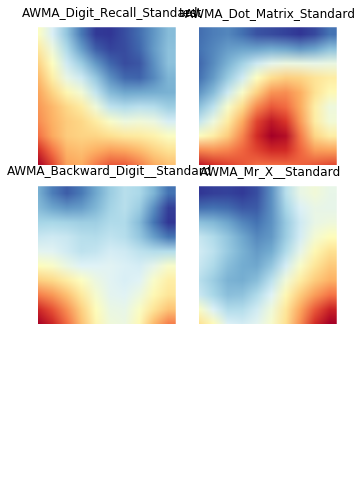

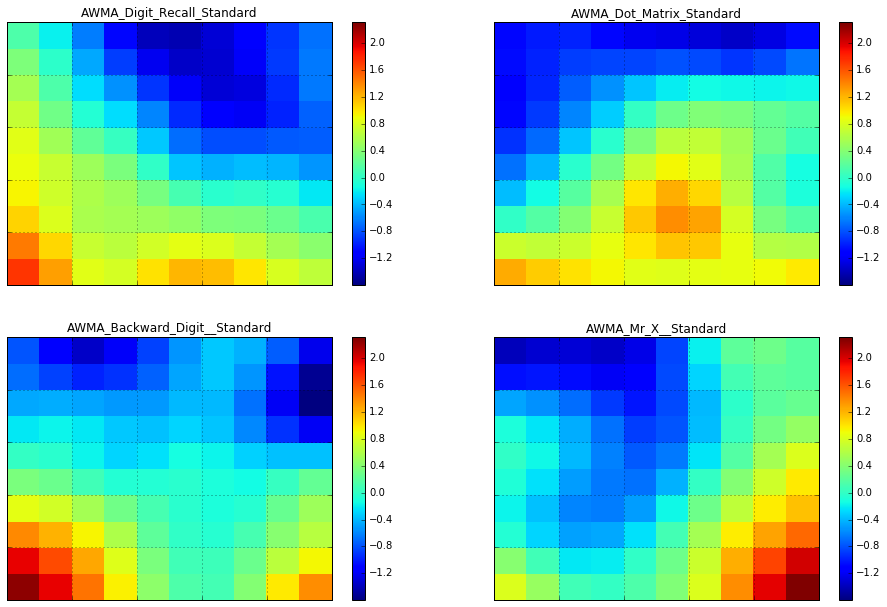

In [6]:
v = sompy.mapview.View2DPacked(20, 20, 'test',text_size=8)  
v.show(sm, what='codebook', cmap=None, col_sz=2) #which_dim='all' default
# v.save('/Users/mz/Desktop/feature_map')

#alternative way (map not rendered)
view2D  = sompy.visualization.mapview.View2D(20,20,"rand data",text_size=10)
view2D.show(sm, col_sz=2, which_dim="all", desnormalize=False)

#Hits map

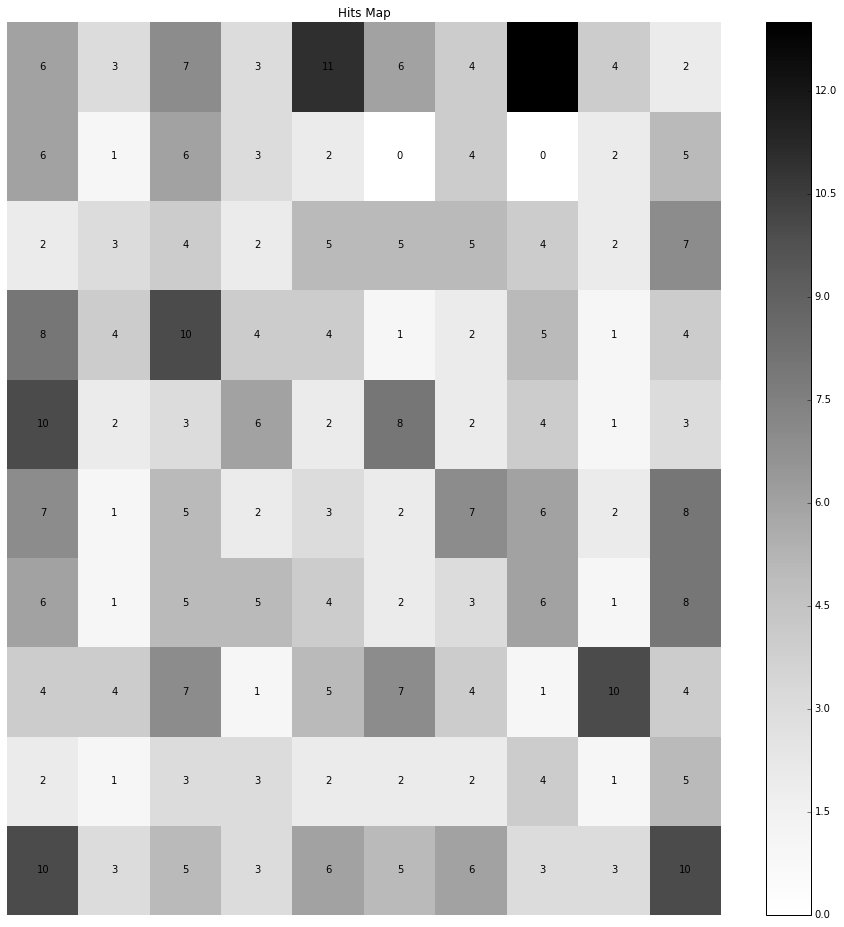

In [7]:
vhts  = sompy.visualization.bmuhits.BmuHitsView(2,2,"Hits Map",text_size=10)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Greys", logaritmic=False)
#vhts.save('C:/Users/mz01/Desktop/BlahBlah/hitmap')

#Kmean clustering

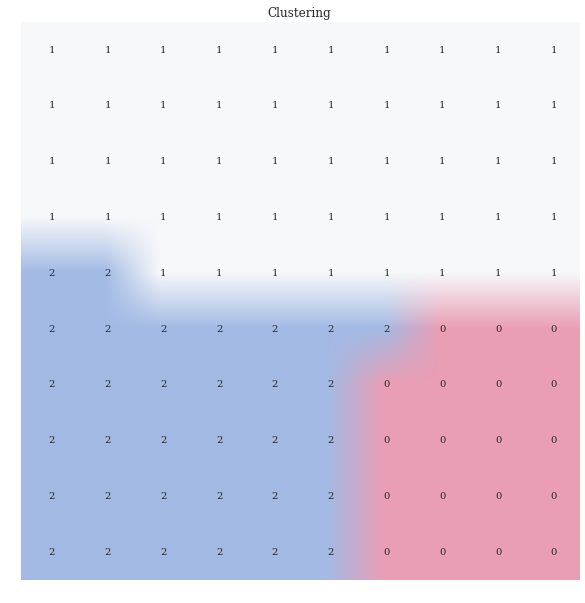

In [8]:
sm.cluster(3)
cluster_label= sm.cluster_labels
hits  = sompy.visualization.hitmap.HitMapView(10,10,"Clustering",text_size=8)
hits.show(sm)
#hits.save('/Users/mz/Desktop/kmean')

# Use SOM and KNN to predict unseen data

In [11]:
def simple_prediction(data, som, K):
    import numpy as np
    target = np.arange(data.shape[1]);dif=[]; prediction=[]
    for j in range(len(target)):
        ind = np.arange(0, data.shape[1])
        indX = ind[ind != target[j]]
        real = data[:,target[j]]
        new_data= data[:,indX]
        target_feature = np.array([target[j]]) 
        given_feature = indX
        predicted_value = som.predict_by(new_data,target[j], k=K) #gives out predicted value of given feature (assumed to be the last column of raw data)
        
        if predicted_value.ndim ==1:   #incase of predicting one column
            predicted_value.shape+=(1,)
            
        if real.ndim==1:
            real.shape+=(1,)
        dif.append(((predicted_value-real)))
        prediction.append(predicted_value)
        print(np.mean(np.abs(predicted_value-real)))
    return dif, prediction



In [ ]:
dif0, prediction_list=simple_prediction(data_new,sm,13)
dif0

#To test how extreme data affect prediction accuracy

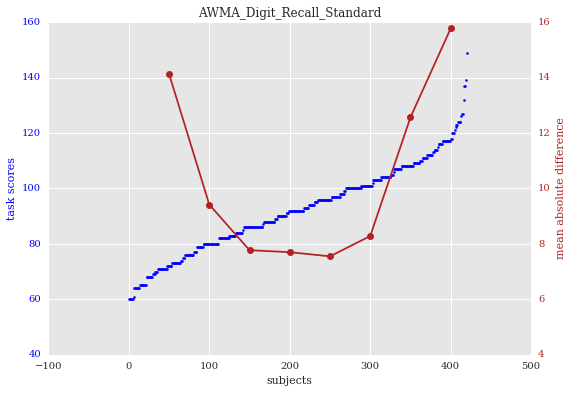

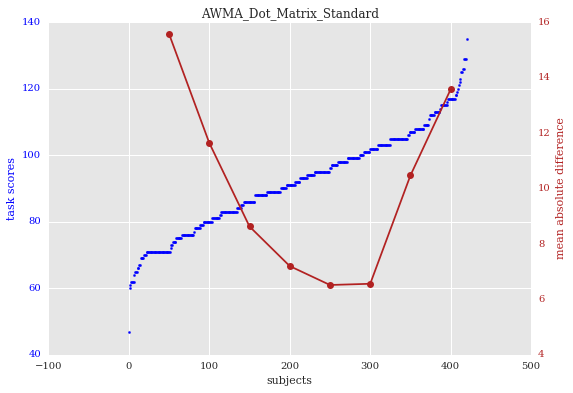

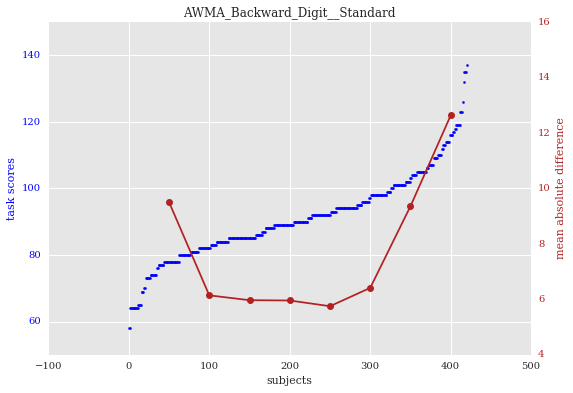

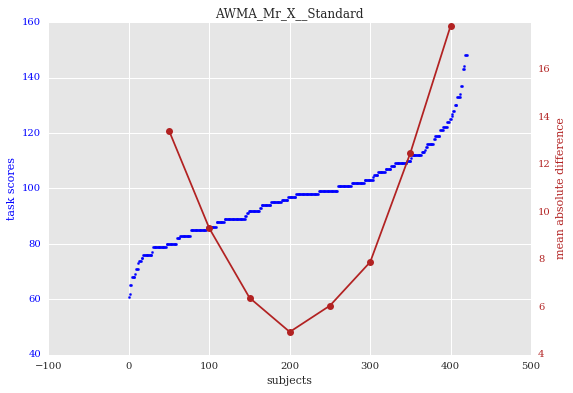

In [9]:
def data_extremity (dataset, label, target, som, num, step, plot=False):
    import math
    if plot==True:
        import seaborn as sns
        sns.set_style("darkgrid", {"axes.facecolor": ".9"})
        sns.set_style({'axes.grid': True,
                       'font.family': [u'serif'],
                       'font.sans-serif': [u'Computer Modern Unicode'],})
    extremity_list = np.zeros([math.ceil((dataset.shape[0]-num)/step)+1, len(target)])
    for j in range(len(target)):
        data_sorted=dataset[dataset[:,target[j]].argsort()] #sort according to the target column
        i=0; ceiling = (math.ceil((dataset.shape[0]-num)/step))+1
        while i < ceiling:
            if i== (math.ceil((dataset.shape[0]-num)/step)):
                data_new1=data_sorted[-num:,:]
            else:
                data_new1=data_sorted[i*step:num+i*step,:]
            ind = np.arange(0, dataset.shape[1])
            indX = ind[ind != target[j]]
            real1 = data_new1[:,target[j]]
            target_feature = np.array([target[j]]) 
            given_feature = indX
            new_data1 = data_new1[:,indX]
            predicted_value1 = som.predict_by(new_data1,target[j], k=10) #gives out predicted value of given feature (assumed to be the last column of raw data)
            predicted_value1.shape+=(1,)
            real1.shape+=(1,)
            
            dif=np.mean(np.abs(predicted_value1-real1))
            extremity_list[i,j]=dif
            i=i+1

            #plot
        if plot == True:
            fig, ax1 = plt.subplots()

            ax1.scatter((np.arange(data_sorted.shape[0])),data_sorted[:,target[j]],marker='.',color='blue')
#            ax1.axvline(i*step,color='r',ls=':')
#            ax1.axvline(num+i*step,color='r',ls=':')
            ax1.set_xlabel('subjects')
            # Make the y-axis label, ticks and tick labels match the line color.
            ax1.set_ylabel('task scores', color='blue')
            ax1.tick_params('y', colors='blue')
            ax1.spines['left'].set_color('blue');
            ax2 = ax1.twinx()
#            ax2.axhline(dif,xmin=(i*step+100)/600,color='g')
            ax2.plot([(2*k*step+num)/2 for k in range(ceiling)], list(extremity_list[:,j]),'-',color='firebrick')
            ax2.plot([(2*k*step+num)/2 for k in range(ceiling)], list(extremity_list[:,j]),'o',color='firebrick')
            ax2.set_ylabel('mean absolute difference', color='firebrick')
            ax2.tick_params('y', colors='firebrick')
            ax2.set_yticks(np.arange(4,18, 2.0))
            ax2.spines['right'].set_color('firebrick');ax2.spines['left'].set_color('blue')
            ax1.set_title(label[target[j]])
            ax2.grid(None)
#            ax2.annotate('%.1f' % dif, xy=(145,dif+0.5), textcoords='data',color='g')
            ax1.spines['top'].set_visible(False);ax2.spines['top'].set_visible(False)
            plt.tight_layout()
            plt.show()
            #fig.savefig('/Users/mz/Desktop/%s%d.png' %(label[target[j]],i))
    return extremity_list

extremity_list_awma= data_extremity(data,names,[0,1,2,3],sm,100,50, plot=True)


#to get a more representative prediction accuracy using sklearn KFold

In [12]:
def som_val(data, mapsize, k=4, names=names):
    import numpy as np
    import sompy
    from sklearn.model_selection import KFold
    temp= data.copy() #pass a copy of data so that shuffle doesn't change the original set
    np.random.shuffle(temp) #reorder the data incaseof any patterns
    dif_mean=np.zeros((k,data.shape[1]))
    kf = KFold(n_splits=k)
    for i, train_index in enumerate(kf.split(temp)):
        print('Training SOM no.', i+1)
        data_train = data[train_index[0]]; data_test = data[train_index[1]]
        print(data_train.shape, data_test.shape)
        sm = sompy.sompy.SOMFactory().build(data_train, [mapsize,mapsize], mask=None, mapshape='planar', 
                                            lattice='rect', normalization='var', initialization='pca', 
                                            neighborhood='gaussian', training='batch', name='sompy',component_names=names)
        sm.train(n_job=1, verbose=None, train_rough_len=10, train_finetune_len=5)
        dif, prediction_list=simple_prediction(data_test,sm,5)
        dif_mean[i,:] = np.mean(np.abs(dif),axis=1).T
    print(np.mean(dif_mean ,axis=0))
    return dif_mean

a= som_val(data,8)
a

 Training...
/Users/mz/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
 pca_linear_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.107000, quantization error: 1.077317



Training SOM no. 1
(315, 4) (106, 4)


 epoch: 2 ---> elapsed time:  0.103000, quantization error: 0.989408

 epoch: 3 ---> elapsed time:  0.117000, quantization error: 0.915044

 epoch: 4 ---> elapsed time:  0.102000, quantization error: 0.875387

 epoch: 5 ---> elapsed time:  0.106000, quantization error: 0.863687

 epoch: 6 ---> elapsed time:  0.106000, quantization error: 0.858228

 epoch: 7 ---> elapsed time:  0.107000, quantization error: 0.853687

 epoch: 8 ---> elapsed time:  0.103000, quantization error: 0.849148

 epoch: 9 ---> elapsed time:  0.105000, quantization error: 0.844603

 epoch: 10 ---> elapsed time:  0.106000, quantization error: 0.841406

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.107000, quantization error: 0.837576

 epoch: 2 ---> elapsed time:  0.108000, quantization error: 0.834824

 epoch: 3 ---> elapsed time:  0.108000, quantization error: 0.832856

 epoch: 4 ---> elapsed time:  0.104000, quantization error: 0.833198

 epoch

11.3415994799
12.439173683
8.26865078901
12.2168664855
Training SOM no. 2
(316, 4) (105, 4)


 epoch: 2 ---> elapsed time:  0.106000, quantization error: 0.970293

 epoch: 3 ---> elapsed time:  0.108000, quantization error: 0.882466

 epoch: 4 ---> elapsed time:  0.108000, quantization error: 0.841369

 epoch: 5 ---> elapsed time:  0.105000, quantization error: 0.824141

 epoch: 6 ---> elapsed time:  0.108000, quantization error: 0.815619

 epoch: 7 ---> elapsed time:  0.104000, quantization error: 0.813313

 epoch: 8 ---> elapsed time:  0.108000, quantization error: 0.813664

 epoch: 9 ---> elapsed time:  0.107000, quantization error: 0.813353

 epoch: 10 ---> elapsed time:  0.104000, quantization error: 0.812598

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.106000, quantization error: 0.811781

 epoch: 2 ---> elapsed time:  0.103000, quantization error: 0.811455

 epoch: 3 ---> elapsed time:  0.104000, quantization error: 0.811044

 epoch: 4 ---> elapsed time:  0.104000, quantization error: 0.810190

 epoch

11.7236975836
11.3403689746
8.54194128482
11.6030912561
Training SOM no. 3
(316, 4) (105, 4)


 epoch: 2 ---> elapsed time:  0.103000, quantization error: 1.001407

 epoch: 3 ---> elapsed time:  0.107000, quantization error: 0.901849

 epoch: 4 ---> elapsed time:  0.108000, quantization error: 0.861891

 epoch: 5 ---> elapsed time:  0.104000, quantization error: 0.846548

 epoch: 6 ---> elapsed time:  0.108000, quantization error: 0.840897

 epoch: 7 ---> elapsed time:  0.105000, quantization error: 0.835823

 epoch: 8 ---> elapsed time:  0.105000, quantization error: 0.834324

 epoch: 9 ---> elapsed time:  0.105000, quantization error: 0.833341

 epoch: 10 ---> elapsed time:  0.106000, quantization error: 0.833162

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.107000, quantization error: 0.832881

 epoch: 2 ---> elapsed time:  0.107000, quantization error: 0.832499

 epoch: 3 ---> elapsed time:  0.106000, quantization error: 0.832499

 epoch: 4 ---> elapsed time:  0.107000, quantization error: 0.832499

 epoch

12.7716997242
10.8229123801
8.82789771503
12.3017002663
Training SOM no. 4
(316, 4) (105, 4)


 epoch: 2 ---> elapsed time:  0.106000, quantization error: 0.999684

 epoch: 3 ---> elapsed time:  0.108000, quantization error: 0.919549

 epoch: 4 ---> elapsed time:  0.109000, quantization error: 0.872255

 epoch: 5 ---> elapsed time:  0.107000, quantization error: 0.850038

 epoch: 6 ---> elapsed time:  0.104000, quantization error: 0.842251

 epoch: 7 ---> elapsed time:  0.105000, quantization error: 0.839661

 epoch: 8 ---> elapsed time:  0.108000, quantization error: 0.833074

 epoch: 9 ---> elapsed time:  0.107000, quantization error: 0.831129

 epoch: 10 ---> elapsed time:  0.108000, quantization error: 0.829261

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.108000, quantization error: 0.829285

 epoch: 2 ---> elapsed time:  0.108000, quantization error: 0.828593

 epoch: 3 ---> elapsed time:  0.103000, quantization error: 0.828514

 epoch: 4 ---> elapsed time:  0.106000, quantization error: 0.828162

 epoch

12.6422019315
11.8837229893
9.48366748249
11.6597619981
[ 12.11979968  11.62154451   8.78053932  11.945355  ]


array([[ 11.34159948,  12.43917368,   8.26865079,  12.21686649],
       [ 11.72369758,  11.34036897,   8.54194128,  11.60309126],
       [ 12.77169972,  10.82291238,   8.82789772,  12.30170027],
       [ 12.64220193,  11.88372299,   9.48366748,  11.659762  ]])

## To obtain null distribution of prediction accuracy using permutation

In [59]:
def perm_distribution(data, kF = 8, knn = 10, rep1 =10, rep2 = 100):
    from scipy import stats
    from sklearn.model_selection import KFold
    repetition=rep1 # Number of times for resampling subjects
    repetition2 = rep2 #Number of times for shuffling group membership (real & predicted value)
    target = np.arange(data.shape[1]);
    temp= data.copy() #pass a copy of data so that shuffle doesn't change the original set
    np.random.shuffle(temp)
    kf = KFold(n_splits=kF)
    diflist=[]
    for i in target:
        diflist.append([])
    for i, train_index in enumerate(kf.split(temp)):
        data_train = data[train_index[0]]; data_test = data[train_index[1]]
        sm = sompy.sompy.SOMFactory().build(data_train, [10,10], mask=None, mapshape='planar', 
                                            lattice='rect', normalization='var', initialization='pca', 
                                            neighborhood='gaussian', training='batch', name='sompy',component_names=names)
        sm.train(n_job=1, verbose=None, train_rough_len=10, train_finetune_len=5)
        m1= np.zeros([int(data_test.shape[0]*4/5),1])#creating a mask that resample 4/5 of subjects from data_new each time
        m2 = np.ones([data_test.shape[0] - m1.shape[0],1])
        m3 = np.append(m1,m2,axis=0)
        m3 = ~np.any(m3,axis=1)      
        dif_list=[]
        for n in target:
            dif=[];  
            ind = np.arange(0, data.shape[1])
            indX = ind[ind != target[n]]
            target_feature = np.array([target[n]]) 
            given_feature = indX
            for i in range(repetition):    
                data_subset = data_test[np.random.permutation(m3)] #bootstrapping
                real = data_subset[:,target[n]]
                new_data= data_subset[:,indX]   
                t1 = sm.predict_by(new_data,target[n], k=knn) 
                t2 = real   
                for j in range(repetition2):
                    dif.append(np.mean(np.abs(np.random.permutation(t1)-t2))) #element by element substraction then average
        
            dif.sort()#dif needs to be a list, norm.pdf doesn't work well with np array
            dif_list.append(dif)
        [x.extend(y) for x,y in zip(diflist,dif_list)]
    [x.sort() for x in diflist]
    return diflist

In [60]:
distribution = perm_distribution(data)

/Users/mz/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/mz/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


#Plot null distribution

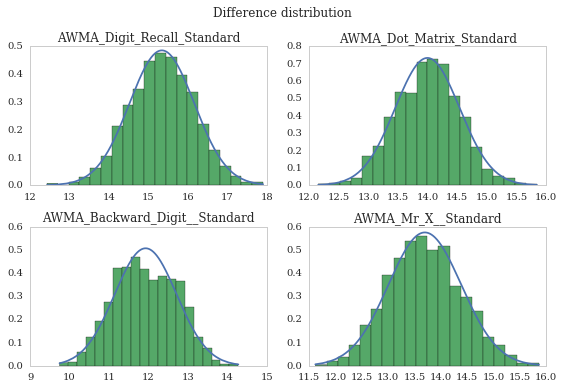

In [62]:
def plot_distribution(dif_list, dif_list2=None):
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                       'font.family': [u'serif'],
                       'font.sans-serif': [u'Computer Modern Unicode'],})
    fig=plt.figure()
    
    for i in range(len(dif_list)):
        dif_list[i].sort()
        difmean = np.mean(dif_list[i])
        difstd=np.std(dif_list[i])
        pdf=stats.norm.pdf(dif_list[i],difmean,difstd) #probability density function
        fig.add_subplot(2, 2, i+1)
        plt.plot(dif_list[i],pdf,'-')
        plt.title(names[i])
        if dif_list2!=None:
            dif_list2[i].sort()
            difmean2 = np.mean(dif_list2[i])
            difstd2=np.std(dif_list2[i])
            pdf2=stats.norm.pdf(dif_list2[i],difmean2,difstd2)
            plt.plot(dif_list2[i],pdf,'-')
        plt.hist(dif_list[i],bins=20,normed=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.suptitle('Difference distribution')
    plt.show()

plot_distribution(distribution)

#Representation dissimilarity matrix of feature maps

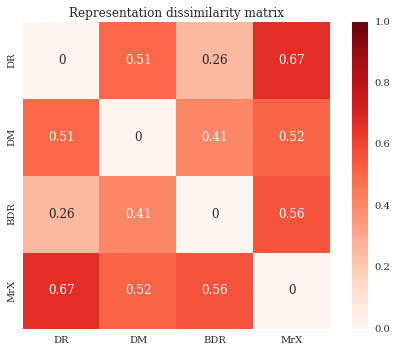

In [65]:
def RDM(som,labels=['DR','DM','BDR','MrX'],show=True):
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})
    cov_matrix= 1-np.corrcoef(som.codebook.matrix.T) #Pearson's r. each row is a variable, colomn an observation
    di=np.diag_indices(cov_matrix.shape[0],ndim=2)
    cov_matrix[di]=0
    if show==True:
        ax=plt.subplot()
#        cmap = sns.diverging_palette(240, 10, as_cmap=True) # Generate a custom diverging colormap
        sns.heatmap(cov_matrix,annot=True,vmin=0,vmax=1, square=True,cmap='Reds')
#        plt.pcolor(cov_matrix[::-1],vmin=0,vmax=1,cmap='RdYlBu_r')
#        plt.colorbar()
        ax.set_xticks(np.arange(0.5,0.5+cov_matrix.shape[0],1))
        ax.set_yticks(np.arange(0.5,0.5+cov_matrix.shape[0],1))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels[::-1])
        plt.title('Representation dissimilarity matrix')
        plt.show()
    
    return cov_matrix
    
cov=RDM(sm,show=True)

#compare RDMs

In [ ]:
def RDM_compare(m1,m2,repetition):
    from scipy.stats import spearmanr
    rdm1 = m1[np.triu_indices(m1.shape[0])]; rdm1.shape+=(1,)
    rdm2 = m2[np.triu_indices(m2.shape[0])]; rdm2.shape+=(1,)
    R = spearmanr(rdm1,rdm2)[0]
    r_list=[]
    for i in range(repetition):
        idx = np.random.permutation(rdm1)
        r =spearmanr(idx,rdm2)[0]
        r_list.append(r)
    diffCount = len(np.where(np.asarray(r_list) <= R)[0])
    p = (1.0 - (float(diffCount)/float(len(r_list))))
    return p, R
        
RDM_compare(cov1,cov2,1000)

In [ ]:
#To test whether two relatedness values are significantly different 


In [ ]:
def RDM_relatedness_test(m1, m2, m_constant):
    from scipy.stats import spearmanr
    p1, R1 = RDM_compare(m_constant,m1,1000)
    p2, R2 = RDM_compare(m_constant,m2,1000)
    rdm1 = m1[np.triu_indices(m1.shape[0])]; rdm1.shape+=(1,)
    rdm2 = m2[np.triu_indices(m2.shape[0])]; rdm2.shape+=(1,)
    rdm = np.append(rdm1,rdm2,axis=0)
    m_constant=m_constant[np.triu_indices(m_constant.shape[0])]; m_constant.shape+=(1,)
    IND = np.arange(0,rdm.shape[0])
    r_list=[]
    for i in range(10000):
        ind=np.random.permutation(IND)
        temp1 = rdm[ind[0:10]]
        temp2 = rdm[ind[10:]]
        r1 =spearmanr(m_constant,temp1)[0]
        r2 =spearmanr(m_constant,temp2)[0]
        r_list.append(r2-r1)
    diffCount = len(np.where(np.asarray(r_list) <= (R2-R1))[0])
    p = (1.0 - (float(diffCount)/float(len(r_list))))
    return p, R1, R2
    
RDM_relatedness_test(cov1,cov2,cov_top)   

#Spring plot

/Users/mz/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


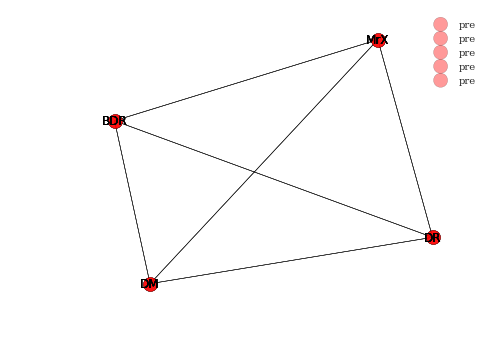

In [71]:
def RDM_springplot(m1,m2=None,m3=None):
    import networkx as nx
    G=nx.from_numpy_matrix(m1)   # this would be the dissimilarity matrix from your analysis
    #fixed the first node at (0.5,0.5)
    position=nx.spring_layout(G,fixed=[1],pos={0:[0.5,0.5],1:[0,0],2:[0,1] ,3:[1,1]})
    nx.draw_networkx_nodes(G, position, node_size=200,label='pre',alpha=0.4)
    nx.draw_networkx_labels(G,position,labels={0:'DR',1:'DM',2:'BDR' ,3:'MrX'})
    nx.draw_networkx_edges(G, position, width=0.5,alpha=0.5,edge_shape='-')

    if m2 is not None:
        G2=nx.from_numpy_matrix(m2)   
        position2=nx.spring_layout(G2,fixed=[1],pos={0:[0.5,0.5],1:[0,0],2:[0,1] ,3:[1,1]})
        nx.draw_networkx_nodes(G2, position2, node_color='g',node_shape='^',alpha=0.4,node_size=200,label='post')
        nx.draw_networkx_labels(G2,position2,labels={0:'DR',1:'DM',2:'BDR' ,3:'MrX'})
        nx.draw_networkx_edges(G2, position2, width=0.5,alpha=0.5)
    if m3 is not None:
        G3=nx.from_numpy_matrix(m3)   
        position3=nx.spring_layout(G3,fixed=[0],pos={0:[0.5,0.5],1:[0,0],2:[0,1] ,3:[1,1]})
        nx.draw_networkx_nodes(G3, position3, node_color='b',node_shape=(5,1),node_size=200,alpha=0.4)
        nx.draw_networkx_labels(G3,position3,labels={0:'DR',1:'DM',2:'BDR' ,3:'MrX'})
    plt.axis('off')
    plt.legend()
    plt.show()
RDM_springplot(1-cov) #1-RDM

# get individual movement on map clusters

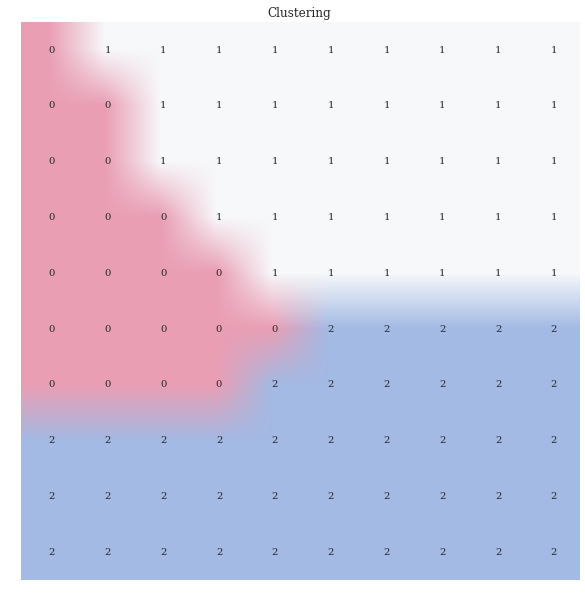

In [75]:
sm.cluster(3)
#sm.cluster_labels[np.where(sm.cluster_labels==1)]=3 #rename clusters to be consistent
#sm.cluster_labels[np.where(sm.cluster_labels==0)]=4
#sm.cluster_labels[np.where(sm.cluster_labels==4)]=1
hits  = sompy.visualization.hitmap.HitMapView(10,10,"Clustering",text_size=8)
hits.show(sm)
bmu_pre= sm.project_data(data_pre) #project new data to the trained map
bmu_post = sm.project_data(data_post)
#get cluster label for new data
coor_pre =  sm.cluster_labels[bmu_pre]; coor_pre.shape+=(1,) 
coor_post = sm.cluster_labels[bmu_post];coor_post.shape+=(1,)
coor_comb = np.append(coor_pre,coor_post,axis=1)
coor_calm = sm.cluster_labels[sm.project_data(data)]; coor_calm.shape+=(1,)


#to get mean and se per cluster to make sue plot

In [77]:
def arrayCount(arr,target):#row by row comparison with a given tuple (x,y)
    from scipy.stats import sem
    count=0
    for i in range(arr.shape[0]):
        if tuple(arr[i,:])==target:
            count+=1
    if count<=2:
        print('no data in this category %s' %(target,))
        return count
    else:
        a = np.where((arr == target).all(axis=1))[0]
        m_pre = np.mean(data_pre[a,:],axis=0)
        m_post=  np.mean(data_post[a,:],axis=0)
        sem_pre = 1.96* sem(data_pre[a,:],axis=0) #95% confidence interval
        sem_post = 1.96* sem(data_post[a,:],axis=0)
        m_change = np.mean(data_post[a,:]-data_pre[a,:],axis=0)
        sem_change = 1.96* sem(data_post[a,:]-data_pre[a,:],axis=0)
        label = np.array(target)
        print('%s in this category %s' %(count,(target,)))
        return count, np.round(m_pre,decimals=0),np.round(m_post,decimals=0),np.round(sem_pre,decimals=0),np.round(sem_post,decimals=0), label,m_change, sem_change

import itertools
group = list(itertools.product([0,1,2],repeat=2)) #repeat = 1 or 2
count=[];m_pre=[];m_post=[];std_pre=[];std_post=[];labels=[];m_change=[];std_change=[]
for i,combination in enumerate(group):
    try:
        a,b,c,d,e,f,g,h = arrayCount(coor_comb,combination) #or coor_pre, coor_post
        count.append(a);m_pre.append(b);m_post.append(c);std_pre.append(d);std_post.append(e); labels.append(f);m_change.append(g);std_change.append(h)
    except Exception:
        pass

18 in this category ((0, 0),)
4 in this category ((0, 1),)
32 in this category ((0, 2),)
no data in this category (1, 0)
22 in this category ((1, 1),)
45 in this category ((1, 2),)
no data in this category (2, 0)
no data in this category (2, 1)
35 in this category ((2, 2),)


#Line plot

In [85]:
def make_SuePlot(mean, error, binarized_results=None, labels=None, legend=None, name='Sue_Plot',ylim=True):
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})
    colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'blue','darkorchid']
#    colours = [ 'firebrick', 'limegreen', 'darkorange', 'blue','darkorchid']
#    colours = [ 'darkorange', 'blue','darkorchid']
#    plt.figure(figsize=(width, width*0.8), dpi=600,frameon=False)
    plt.figure()
    for i in range(len(mean)):
        plt.errorbar((np.array(range(len(mean[i])))+0.04*i),mean[i], yerr=error[i], color=colours[i])
 
    plt.xlim([-0.5,len(mean[0])-0.5])
    if ylim==True: plt.ylim([60,140])
    else: plt.ylim([-10,40])
    plt.xticks(range(0,len(mean[0])))
    if legend is not None:
        plt.legend([list(community) for community in legend ], frameon=True, loc=1)
    else: 
        plt.legend([ 'C' + str(community+1) for community in range(len(mean)) ], frameon=True, loc=1)
    plt.ylabel('stantard_scores')
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticklabels(labels, rotation=45);
    plt.title(name)
    plt.show()

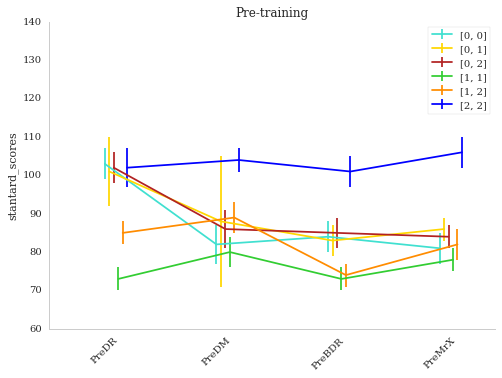

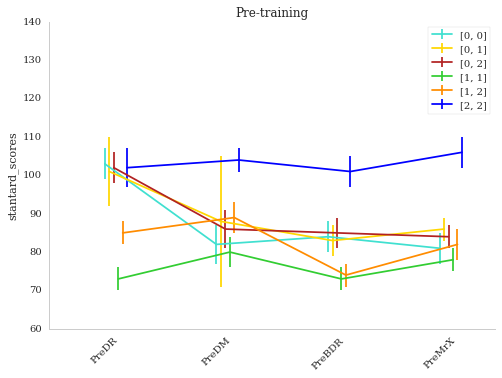

In [86]:
make_SuePlot(m_pre,std_pre, labels=name_pre,legend=labels, name='Pre-training')
